In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
pip install tensorflow

In [4]:
#dataset
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42
data='./garbage'

In [33]:
import matplotlib.pyplot as plt

In [11]:
import os
print(os.listdir(r'C:\Users\Hp\OneDrive\Desktop\garbage\Garbage classification\Garbage classification'))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [18]:
data1=r'C:\Users\Hp\OneDrive\Desktop\garbage\Garbage classification\Garbage classification'

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data1,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data1,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)



Found 2527 files belonging to 6 classes.
Using 1769 files for training.
Found 2527 files belonging to 6 classes.
Using 758 files for validation.


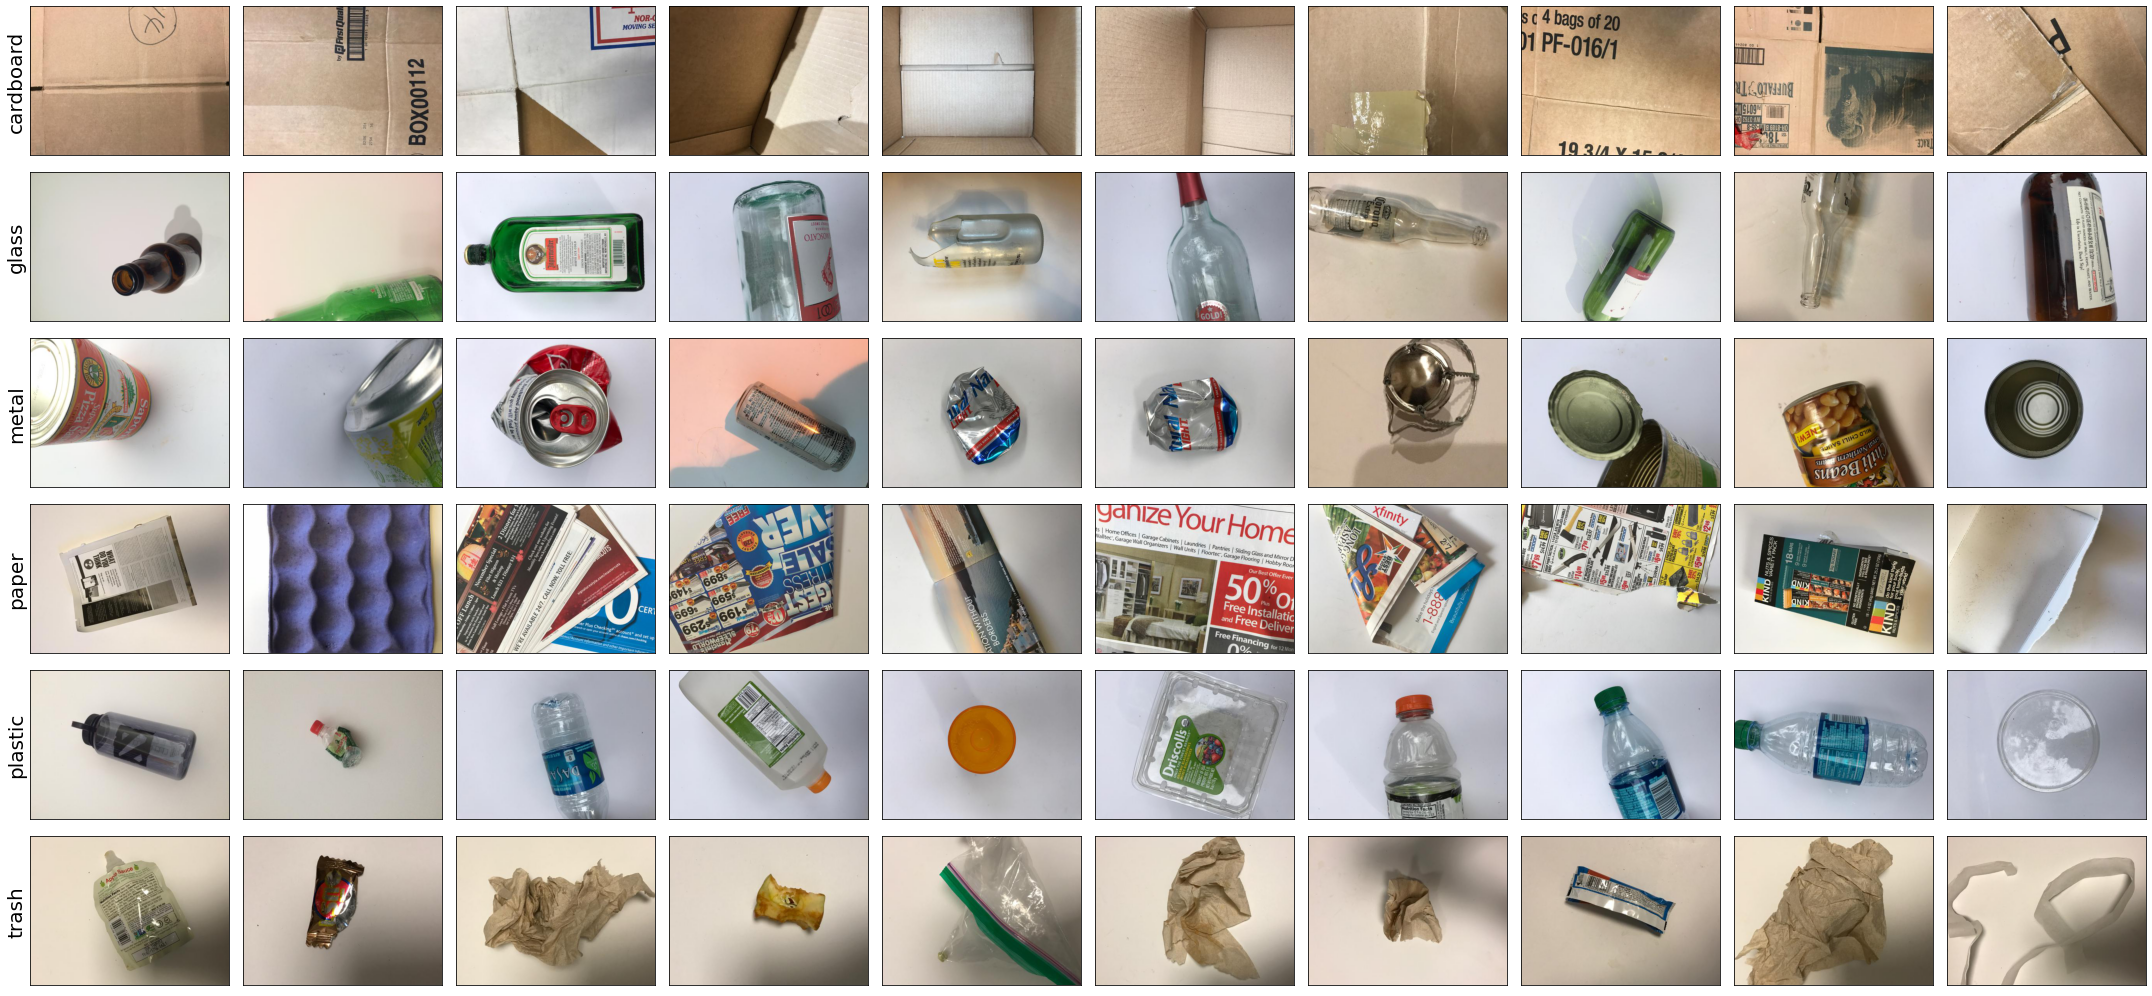

In [31]:
import matplotlib.image as mpimg
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
plt.figure(figsize=(30,14))

for i in range(6):
    directory = os.path.join(data1,labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [35]:
classes = train_ds.class_names

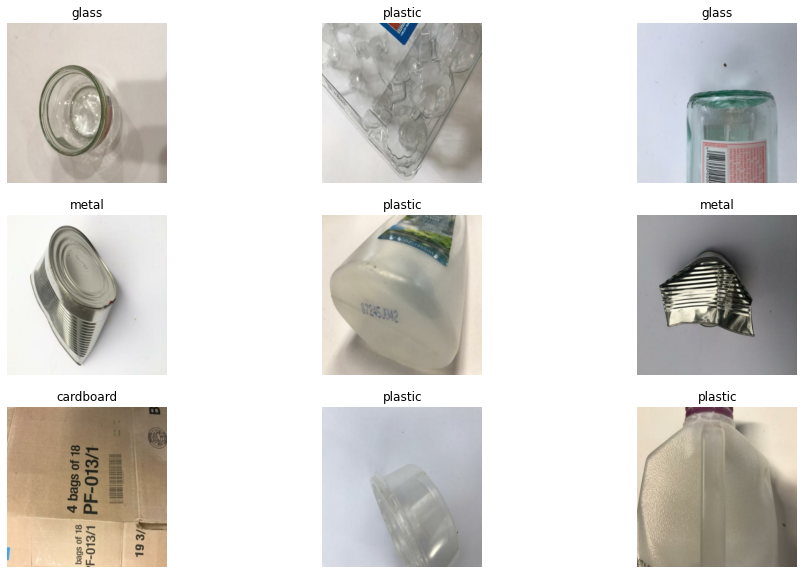

In [36]:
plt.figure(figsize=(16, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

In [37]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [38]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [39]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)
